In [308]:
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from matplotlib import cm

import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage

sys.path.append(os.getcwd())
sys.path.append(os.getcwd()+"\\DB")
sys.path.append(os.getcwd()+"\\CRNN")

import DB.model as dbmodel
from DB.inference import resize_image, polygons_from_bitmap
import CRNN.models.crnn as crnnmodel
import CRNN.dataset as dataset, utils

In [415]:
class Interpreter():
    
    def __init__(self, alphabet = '0123456789abcdefghijklmnopqrstuvwxyz'):
        _, self.db = dbmodel.dbnet()
        self.db.load_weights('DB/weights/db_48_2.0216_2.5701.h5', skip_mismatch = True)

        self.crnn = crnnmodel.CRNN(32, 1, 37, 256)
        self.crnn.load_state_dict(torch.load('CRNN/data/crnn.pth'))
        
        self.converter = utils.strLabelConverter(alphabet)
        self.transformer = dataset.resizeNormalize((100, 32))
        
        self.mean = np.array([103.939, 116.779, 123.68])
        self.alphabet = alphabet
        
    def findChars(self, images):
        ret = []
        for image in images:
            image = cv2.imread(image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            src_img = image.copy()
            h, w = image.shape[:2]
            image = resize_image(image)
            image = image.astype(np.float32)
            image -= self.mean
            image_input = np.expand_dims(image, axis = 0)
            p = self.db.predict(image_input)[0]
            bitmap = p>0.3
            boxes, scores = polygons_from_bitmap(p, bitmap, w, h, box_thresh = 0.5)
            ret.append({
                "boxes": boxes,
                "p": p,
                "bitmap": bitmap,
                "scores": scores,
                "image": src_img
            })
        return ret
        
    def findParts(self, image, contours):        
        shapes = []
        for cnts in contours:
            rect = cv2.minAreaRect(np.float32(cnts))
            shapes.append(rect)
            
        shapes = np.array(shapes)
        return shapes
    
    def cropAndRotate(self, parts):
        src_image, rects = parts[0], parts[1]
        images_fins = []
        
        for rect in rects:
            
            ### NEED TO MAKE THIS DEPEND ON GEOMETRY
            
            image=src_image.copy()
            theta = rect[2]
            width = rect[1][0]
            height = rect[1][1]
            #theta *= 180/np.pi

            point1 = rect[0]
            kp = KeypointsOnImage([
                Keypoint(x = point1[0], y= point1[1])
            ], shape = image.shape)
            seq = iaa.Sequential([
                iaa.Rotate(- theta)
            ])
            image_aug, kps_aug = seq(image=image, keypoints=kp)
            after = kps_aug[0]
            
            #image_fin = image_aug[int(after.y-width/2):int(after.y+width/2),int(after.x-height/2):int(after.x+height/2)]
            image_fin = image_aug[int(after.y-height/2):int(after.y+height/2),int(after.x-width/2):int(after.x+width/2)]
            
            images_fins.append(image_fin)
            
        return images_fins
    
    def readExtracted(self, extracts):
        text = []
        
        for image in extracts:
            
            image = Image.fromarray(image).convert('L')
            
            image = self.transformer(image)
            image = image.view(1, *image.size())
            image = torch.autograd.Variable(image)
            
            self.crnn.eval()
            preds = self.crnn(image)
            
            _, preds = preds.max(2)
            preds = preds.transpose(1,0).contiguous().view(-1)
            
            preds_size = torch.autograd.Variable(torch.IntTensor([preds.size(0)]))
            raw_pred = self.converter.decode(preds.data, preds_size.data, raw=True)
            sim_pred = self.converter.decode(preds.data, preds_size.data, raw=False)
            print('%-20s => %-20s' % (raw_pred, sim_pred))
            text.append(sim_pred)
            
        return text
        
        
    def readImages(self, filenames):
        ret = self.findChars(filenames)
        extracted = {}
        for i in range(len(filenames)):
            extracted[filenames[i]] = (ret[i]["image"], self.findParts(ret[i]["image"], ret[i]["boxes"]))
            patches = self.cropAndRotate(extracted[filenames[i]])
            extracted[filenames[i]] = (patches, self.readExtracted(patches))
        return extracted

39


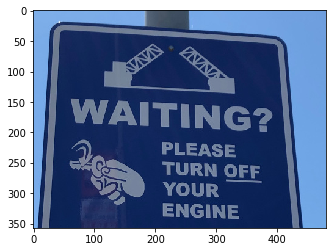

In [418]:
a = Interpreter()
filenames = ["scene_text_test/3.jpg"]
image = cv2.imread(filenames[0])

### NEED TO ADD ERROR HANDLING

ret = a.findChars(filenames)[0]
plt.imshow(ret["image"])

In [419]:
info = a.readImages(filenames)[filenames[0]]
f, axarr = plt.subplots(len(info[0]),1)

if len(info[0]) > 1:
    for i in range(len(info[0])):
        axarr[i].imshow(info[0][i])
elif len(info[0]) == 1:
    axarr.imshow(info[0][0])
else:
    print("Nothing found")

info[1]

39
j------------------n------ => jn                  
2------------------------- => 2                   
j--------------------t---- => jt                  
o-----------f-------f----- => off                 
-5-------------e---------- => 5e                  
p------------------------- => p                   


ValueError: tile cannot extend outside image

In [ ]:
### REFERENCE ###

plt.imshow(ret["image"])

# Prediction from DB
p = ret["p"][:,:,0]
plt.imshow(p)

# Bitmap
bitmap = ret["bitmap"][:,:,0]
plt.imshow(bitmap)
print(bitmap)

boxes = ret["boxes"]
print(len(boxes))

scores = ret["scores"]
print(scores)